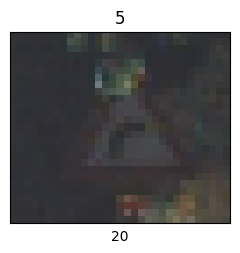

In [1]:
from os import path

from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image


class SignDataset:
    def __init__(self, data_filename: str, data_dir: str, num_classes: int):
        self.labels: list[int] = []
        self.__image_paths: list[str] = []
        self.__num_classes: int = num_classes
        base_dir = path.abspath(data_dir)
        annotations = pd.read_csv(f"{base_dir}/{data_filename}")
        for i, row in annotations.iterrows():
            class_id = int(row['ClassId'])
            image_path = path.join(base_dir, row['Path'])
            self.__image_paths.append(image_path)
            self.labels.append(class_id)

    def plot_sample(self, index: int):
        img = self._load_image(index)
        label = str(self.labels[index])
        fig = plt.figure(tight_layout=True, figsize=(2.5, 2.5))
        axis = fig.add_subplot(1, 1, 1, title=index)
        axis.set_xlabel(str(label))
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(img)
        plt.show()

    def load_data(self) -> tuple[np.ndarray, np.ndarray]:
        images, targets = [], []
        for i in range(len(self.__image_paths)):
            img, target = self[i]
            images.append(img)
            targets.append(target)
        return np.array(images), np.array(targets)

    def __getitem__(self, index: int) -> tuple:
        img = self._load_image(index)
        #smaller_size = min(img.shape[0], img.shape[1])
        resize = layers.Resizing(128, 128, crop_to_aspect_ratio=True)
        img = resize(img).cpu()
        class_id = self.labels[index]
        targets = np.zeros(self.__num_classes)
        targets[class_id-1] = 1
        return img, targets
    
    def _load_image(self, index: int) -> np.ndarray:
        image_path = self.__image_paths[index]
        with Image.open(image_path) as image:
            image_array = np.array(image).astype(np.float32) / 255
        return image_array


train_dataset = SignDataset("Train.csv", "data", 42)
test_dataset = SignDataset("Test.csv", "data", 42)
x_train, y_train = train_dataset.load_data()
x_test, y_test = test_dataset.load_data()
train_dataset.plot_sample(5)

In [ ]:
def plot_loss_history(loss_history: dict[str, list[float]]):
    loss = loss_history["loss"]
    val_loss = loss_history["val_loss"]
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b--", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [14]:
from keras import Model, Sequential
from keras import layers
from keras import losses
from keras import optimizers


class SignDetector(Model):
    def __init__(self, num_classes: int):
        super().__init__()
        self.hidden_layers = Sequential([
            layers.Input(shape=(128, 128, 3)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
            layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
            layers.GlobalAveragePooling2D(),
            layers.Dropout(0.5),
        ])
        self.classifier = layers.Dense(num_classes, activation="softmax")

    def call(self, inputs):
        features = self.hidden_layers(inputs)
        return self.classifier(features)


sign_detector = SignDetector(42)
sign_detector.compile(
    loss=losses.CategoricalCrossentropy(),
    optimizer=optimizers.SGD(learning_rate=0.001))



In [16]:
from keras import callbacks


BATCH_SIZE = 128
EPOCHS = 100

cbs = [
    callbacks.EarlyStopping(monitor="val_loss", patience=7),
    callbacks.ReduceLROnPlateau(monitor="val_loss", patience=4, factor=0.5),
]
history = sign_detector.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=cbs,
    validation_split=0.3)

Epoch 1/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 3.7334 - val_loss: 3.7501 - learning_rate: 0.0010
Epoch 2/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 3.7086 - val_loss: 3.7680 - learning_rate: 0.0010
Epoch 3/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 3.6804 - val_loss: 3.7965 - learning_rate: 0.0010
Epoch 4/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 3.6391 - val_loss: 3.8546 - learning_rate: 0.0010
Epoch 5/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 3.5583 - val_loss: 4.0220 - learning_rate: 0.0010
Epoch 6/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 3.4273 - val_loss: 4.2141 - learning_rate: 5.0000e-04
Epoch 7/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 3.3231 - val_loss: 4.4791 - learning_rate: 5.0000e-04
Epoch 8/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 3.2488 - val_loss: 4.7559 - learning_rate: 5.0000e-04


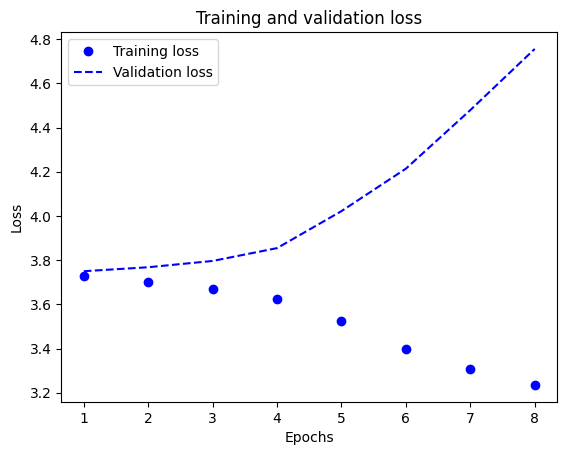

In [17]:
plot_loss_history(history.history)

In [18]:
from sklearn import metrics

y_test = test_dataset.labels
output = sign_detector.predict(x_test)
predictions = np.argmax(output, axis=1) + 1
conf_matrix = metrics.confusion_matrix(y_test, predictions)
print(f"Accuracy: {metrics.accuracy_score(y_test, predictions):.5f}")
print(metrics.classification_report(y_test, predictions))

  1/395 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Accuracy: 0.05701
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.06      1.00      0.11       720
           2       0.00      0.00      0.00       750
           3       0.00      0.00      0.00       450
           4       0.00      0.00      0.00       660
           5       0.00      0.00      0.00       630
           6       0.00      0.00      0.00       150
           7       0.00      0.00      0.00       450
           8       0.00      0.00      0.00       450
           9       0.00      0.00      0.00       480
          10       0.00      0.00      0.00       660
          11       0.00      0.00      0.00       420
          12       0.00      0.00      0.00       690
          13       0.00      0.00      0.00       720
          14       0.00      0.00      0.00       270
          15       0.00      0.00      0.00       210
          16       0.0

/home/diego/miniconda3/envs/mna_py_310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/diego/miniconda3/envs/mna_py_310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/diego/miniconda3/envs/mna_py_310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr